<a href="https://colab.research.google.com/github/LinggarM/Movie-Synopsis-Text-Clustering/blob/main/pba_tugas_besar_movie_synopsis_text_clustering_8000_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kelompok 5 :**

*   ## **Linggar Maretva Cendani**
*   ## **Fetty Krisnaeni**

# Import Dependencies

In [2]:
import json
import requests
import os, shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
path = "/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA"
path_api = "/content/gdrive/MyDrive/Upload/API/"

# Data Collecting

## Retrieve Genres

In [7]:
# Get All Genres

movie_api = open('%sapi_themoviedb.txt' % path_api, 'r').read()
genres = []
for i in range(200) :
  url = ("https://api.themoviedb.org/3/movie/%d?api_key=%s" % (i, movie_api))
  r = requests.get(url)
  json_data = json.loads(r.text)
  try:
    if (json_data['genres'] != "") :
      # print(json_data['genres'])
      for j in json_data['genres'] :
        genre = j.get('name')
        if (genre not in genres) :
          genres.append(genre)
  except Exception:
    pass
print(genres)

['Drama', 'Crime', 'Comedy', 'Action', 'Thriller', 'Documentary', 'Adventure', 'Science Fiction', 'Animation', 'Family', 'Romance', 'Mystery', 'Horror', 'Fantasy', 'War', 'Music', 'History', 'Western', 'TV Movie']


In [8]:
len(genres)

19

## Retrieve Titles & Synopsis

In [9]:
titles = []
synopsis = []

for i in range(20000) :
  url = ("https://api.themoviedb.org/3/movie/%d?api_key=63fea4c709da1f1496b7a1ca7a3c6083" % i)
  r = requests.get(url)
  json_data = json.loads(r.text)
  try:
    if (json_data['overview'] != "" and json_data['overview'] != "No overview found." and json_data['original_language'] == 'en') :
      titles.append(json_data['title'])
      synopsis.append(json_data['overview'])
  except Exception:
    pass

In [10]:
df_movies = pd.DataFrame({'title': titles, 'synopsis': synopsis})

In [11]:
df_movies.head()

,title,synopsis
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
2,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...
3,Star Wars,Princess Leia is captured and held hostage by ...
4,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."


In [12]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8214 entries, 0 to 8213
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     8214 non-null   object
 1   synopsis  8214 non-null   object
dtypes: object(2)
memory usage: 128.5+ KB


In [13]:
with open('%s/movie_synopsis.csv' % path, 'w') as f:
  df_movies.to_csv(f)

# Data Preprocessing

## Import Data

In [5]:
df_movies = pd.read_csv('%s/movie_synopsis_8000_no overview.csv' % path)
df_movies.head()

,title,synopsis
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
2,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...
3,Star Wars,Princess Leia is captured and held hostage by ...
4,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."


In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8457 entries, 0 to 8456
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     8457 non-null   object
 1   synopsis  8457 non-null   object
dtypes: object(2)
memory usage: 132.3+ KB


## Delete Missing Value

In [7]:
# Get names of indexes for which column synopsis has no overview
index_drop = df_movies[df_movies['synopsis'] == "No overview found."].index

# Delete these row indexes from dataFrame
df_movies.drop(index_drop , inplace=True)

# Reset the index
df_movies.reset_index(drop =True, inplace=True)

In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8214 entries, 0 to 8213
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     8214 non-null   object
 1   synopsis  8214 non-null   object
dtypes: object(2)
memory usage: 128.5+ KB


## Case Folding

In [9]:
df_movies["synopsis"] = df_movies["synopsis"].str.lower()
df_movies.head()

,title,synopsis
0,Four Rooms,it's ted the bellhop's first night on the job....
1,Judgment Night,"while racing to a boxing match, frank, mike, j..."
2,Life in Loops (A Megacities RMX),timo novotny labels his new project an experim...
3,Star Wars,princess leia is captured and held hostage by ...
4,Finding Nemo,"nemo, an adventurous young clownfish, is unexp..."


## TF-IDF Training

In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(df_movies['synopsis'].values) # training vector TF-IDF pada tiap data

# vector TF-IDF tiap kalimat (features), pasangan index kata dan nilainya
for i in features :
  print(i)
  print('-----------------------------')

Streaming output truncated to the last 5000 lines.
  (0, 12973)	0.14483275104625953
  (0, 13149)	0.13334586172540167
  (0, 24957)	0.13582667519419955
  (0, 19440)	0.15240864127004877
  (0, 22836)	0.1473720700967724
  (0, 13120)	0.17393621751782645
  (0, 8265)	0.1513027940750261
  (0, 8289)	0.11682112768112195
  (0, 25181)	0.13863052877378373
  (0, 9008)	0.13863052877378373
  (0, 24913)	0.12196110094053371
  (0, 3447)	0.1071559827980113
  (0, 26174)	0.11682112768112195
  (0, 9127)	0.12797983875545338
  (0, 18845)	0.11111454318249671
  (0, 5267)	0.13112128247827526
  (0, 10409)	0.09228187772399131
  (0, 3986)	0.13112128247827526
  (0, 15067)	0.10757735048365544
  (0, 27070)	0.07234665066262949
  (0, 9308)	0.08432181315756035
-----------------------------
  (0, 12857)	0.2131956414188282
  (0, 7006)	0.20392116623243212
  (0, 17420)	0.20392116623243212
  (0, 24874)	0.1814860013138223
  (0, 14253)	0.20392116623243212
  (0, 12384)	0.1845403543585994
  (0, 5709)	0.16710741411314206
  (0, 25391

In [20]:
# Save Model
pickle.dump(vectorizer, open('%s/vectorizer.sav'  % path, 'wb'))

In [21]:
# Load Model
vectorizer = pickle.load(open('%s/vectorizer.sav'  % path, 'rb'))

In [22]:
# Save Model
pickle.dump(features, open('%s/features.sav'  % path, 'wb'))

In [23]:
# Load Model
features_new_pickle = pickle.load(open('%s/features.sav'  % path, 'rb'))

# KMeans Model

## KMeans Model Training

In [14]:
k = 14 # jumlah cluster

In [15]:
kmeans_model = KMeans(n_clusters = k)
synopsis_clusters = kmeans_model.fit(features)

In [26]:
# Save Model
pickle.dump(kmeans_model, open('%s/kmeans_model.sav' % path, 'wb'))

In [27]:
# Load Model
kmeans_model = pickle.load(open('%s/kmeans_model.sav'% path, 'rb'))

## Data Labelling

In [16]:
df_movies['label'] = kmeans_model.labels_
df_movies.head()

,title,synopsis,label
0,Four Rooms,it's ted the bellhop's first night on the job....,3
1,Judgment Night,"while racing to a boxing match, frank, mike, j...",3
2,Life in Loops (A Megacities RMX),timo novotny labels his new project an experim...,2
3,Star Wars,princess leia is captured and held hostage by ...,3
4,Finding Nemo,"nemo, an adventurous young clownfish, is unexp...",3


In [29]:
with open('%s/movie_synopsis_labeled.csv' % path, 'w') as f:
  df_movies.to_csv(f)

## Data Distribution

In [30]:
movie_clusters = df_movies.groupby('label')

clusters_count = []
for cluster in movie_clusters :
    clusters_count.append(len(cluster[1]))

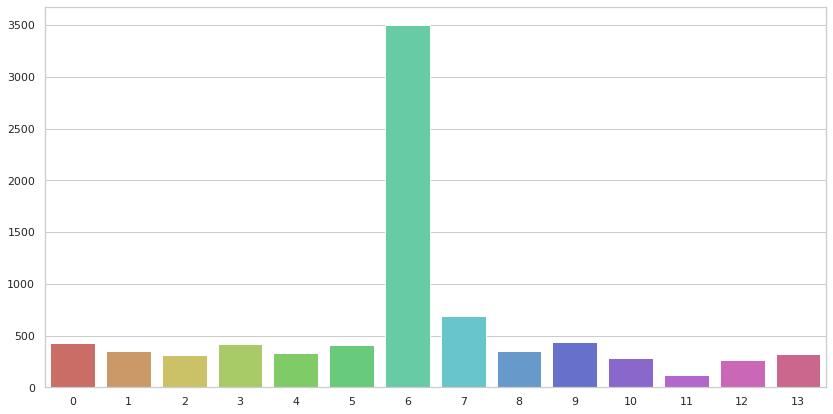

In [31]:
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")
graph = sns.barplot(x = np.arange(k), y = clusters_count, palette='hls')

# Data from each Cluster

## Data Preview for each Cluster

In [32]:
clusters = df_movies.groupby('label')

for cluster in clusters.groups :
  print("Cluster %d : " % cluster)
  data_cluster = clusters.get_group(cluster)[['title','synopsis']]
  for i in range(5) :
    data = data_cluster.iloc[i]
    print('   ', data['title'], ': ', data['synopsis'])
  print('\n')

Cluster 0 : 
    2001: A Space Odyssey :  humanity finds a mysterious object buried beneath the lunar surface and sets off to find its origins with the help of hal 9000, the world's most advanced super computer.
    Charlie and the Chocolate Factory :  a young boy wins a tour through the most magnificent chocolate factory in the world, led by the world's most unusual candy maker.
    King Kong :  adventurous filmmaker, carl denham, sets out to produce a motion picture unlike anything the world has seen before. alongside his leading lady ann darrow and his first mate jack driscoll, they arrive on an island and discover a legendary creature said to be neither beast nor man. denham captures the monster to displayed on broadway as kong, the eighth wonder of the world.
    Willy Wonka & the Chocolate Factory :  eccentric candy man willy wonka prompts a worldwide frenzy when he announces that golden tickets hidden inside five of his delicious candy bars will admit their lucky holders into hi

## Save All Data from each Cluster

In [33]:
folder = ('%s/csv cluster' % path)
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [34]:
clusters = df_movies.groupby('label')

for cluster in clusters.groups :
    f = open(('%s/csv cluster/cluster'  % path)+str(cluster)+ '.csv', 'w') # buat file csv untuk tiap cluster
    data = clusters.get_group(cluster)[['title','synopsis']] # judul dan sinposis tiap data pada tiap cluster
    f.write(data.to_csv(index_label='id')) # simpan ke csv
    f.close()

# Feature Names of each Cluster

In [35]:
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1] # diurutkan berdasarkan indeks -> lalu di-reversed
terms = vectorizer.get_feature_names()
n_terms = 10

feature_names = [[0 for x in range(n_terms)] for y in range(k)] 
for i in range(k) :
	print("Cluster %d :" % i)
	j_counter = 0
	for j in order_centroids [i, :n_terms] :
		print('   %s' % terms[j])
		feature_names[i][j_counter] = terms[j]
		j_counter += 1
	print('----------')

Cluster 0 :
   world
   life
   time
   year
   team
   story
   way
   new
   finds
   lives
----------
Cluster 1 :
   woman
   young
   husband
   love
   man
   life
   finds
   falls
   beautiful
   daughter
----------
Cluster 2 :
   school
   high
   student
   teacher
   students
   friends
   new
   girl
   girls
   life
----------
Cluster 3 :
   police
   boy
   detective
   case
   murder
   officer
   young
   cop
   investigation
   old
----------
Cluster 4 :
   town
   killer
   small
   serial
   sheriff
   fbi
   local
   victims
   murder
   young
----------
Cluster 5 :
   new
   york
   city
   life
   old
   young
   love
   year
   time
   discovers
----------
Cluster 6 :
   life
   young
   story
   time
   group
   finds
   friends
   help
   way
   american
----------
Cluster 7 :
   family
   love
   life
   father
   mother
   home
   old
   brother
   young
   falls
----------
Cluster 8 :
   film
   documentary
   movie
   director
   life
   story
   series
   b

In [36]:
with open('%s/feature_names.csv' % path, 'w') as f:
  pd.DataFrame(feature_names).to_csv(f)

Cluster: 0


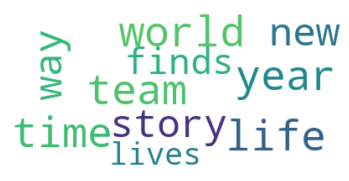

Cluster: 1


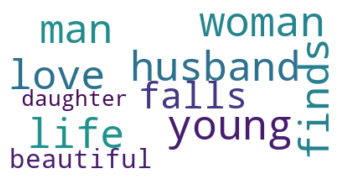

Cluster: 2


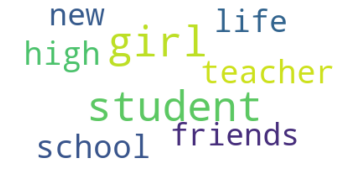

Cluster: 3


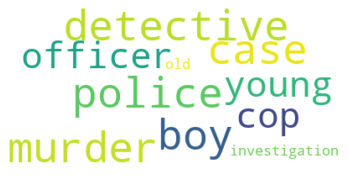

Cluster: 4


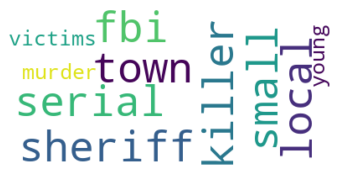

Cluster: 5


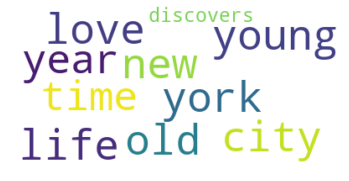

Cluster: 6


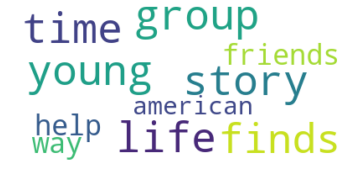

Cluster: 7


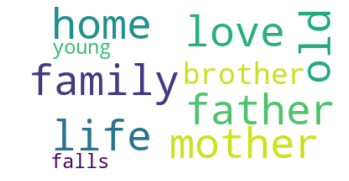

Cluster: 8


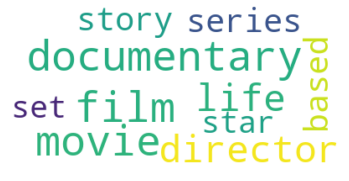

Cluster: 9


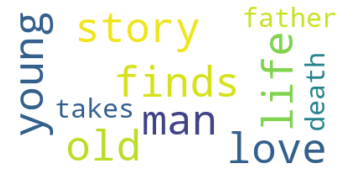

Cluster: 10


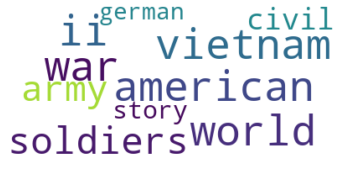

Cluster: 11


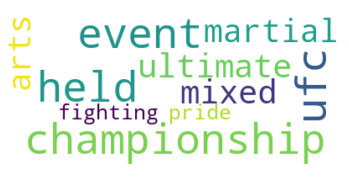

Cluster: 12


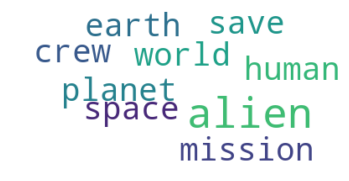

Cluster: 13


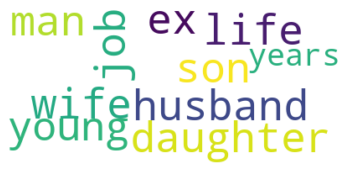

In [37]:
c = []
keywords = []
for i in range(k) :
  c.append(i)
  key = ""
  for j in order_centroids [i, :n_terms] :
    key = key+(" ")+(terms[j])
  keywords.append(key)

for i in range(k) :
  print('Cluster: %d' % c[i])
  text = keywords[i]
  wordcloud = WordCloud(max_font_size=50, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.savefig('%s/wordcloud/wordcloud%d.jpg' % (path, i))
  plt.show()

# Cluster Prediction and Recommendation

In [38]:
def predict_cluster(sentence) :
  Y = vectorizer.transform([sentence])
  prediction = kmeans_model.predict(Y)
  cluster_prediction = prediction[0]
  print("Sentence           : ", sentence)
  print("Cluster predicted  : ", cluster_prediction)

def movie_recommendation(n, query, features, vectorizer, df_movies) :
  query = [query.lower()]
  query = vectorizer.transform(query)

  cosine_score = []
  index = 0
  for i in features :
    cosine_score.append(cosine_similarity(query, i))
    index +=1

  cosine_score_update = []
  for i in cosine_score :
    cosine_score_update.append(i[0][0])
  cosine_score_update = np.array(cosine_score_update)
  cosine_score_update
  indices = np.argsort(cosine_score_update)[::-1]

  for i in range(n) :
    index_now = indices[i]
    if (cosine_score_update[index_now] != 0) :
      print(i, " . ", df_movies['title'][index_now], " : ", cosine_score_update[index_now], " : ", df_movies['synopsis'][index_now])

def movie_recommendation_by_title(n, title, features, vectorizer, df_movies) :
  
  synopsis_ori = ""
  title_new = ""
  url = ("https://api.themoviedb.org/3/search/movie?api_key=63fea4c709da1f1496b7a1ca7a3c6083&language=en-US&query=%s&page=1&include_adult=false" % title)
  r = requests.get(url)
  json_data = json.loads(r.text)
  try:
    if (json_data['results'][0]['overview'] != "") :
      title_new = json_data['results'][0]['title']
      synopsis_ori = json_data['results'][0]['overview']
  except Exception:
    pass
  
  synopsis = [synopsis_ori.lower()]
  synopsis = vectorizer.transform(synopsis)

  cosine_score = []
  index = 0
  for i in features :
    cosine_score.append(cosine_similarity(synopsis, i))
    index +=1

  cosine_score_update = []
  for i in cosine_score :
    cosine_score_update.append(i[0][0])
  cosine_score_update = np.array(cosine_score_update)
  cosine_score_update
  indices = np.argsort(cosine_score_update)[::-1]

  print("Title Query : ", title)
  print(title_new, " : ", synopsis_ori, "\n")
  for i in range(n) :
    index_now = indices[i]
    if (cosine_score_update[index_now] != 0) :
      print(i, " . ", df_movies['title'][index_now], " : ", cosine_score_update[index_now], " : ", df_movies['synopsis'][index_now])

## Predict Sentences

In [39]:
sentence = "Britain declared war on Germany in september 1939 and begin world war 2"

predict_cluster(sentence)

Sentence           :  Britain declared war on Germany in september 1939 and begin world war 2
Cluster predicted  :  10


In [40]:
sentence = "There are a lot of aliens at space"

predict_cluster(sentence)

Sentence           :  There are a lot of aliens at space
Cluster predicted  :  12


In [41]:
sentence = "Johnstone's Family is very nice family"

predict_cluster(sentence)

Sentence           :  Johnstone's Family is very nice family
Cluster predicted  :  7


## Movie Recommendation (by Query/ Synopsis)

In [42]:
n = 10
query = "Johnstone's Family is very nice family"

print("Synopsis : ", query, "\n")
movie_recommendation(n, query, features, vectorizer, df_movies)

Synopsis :  Johnstone's Family is very nice family 

0  .  The Seven Days  :  0.35124994703536483  :  when one of the brothers (ohayn) dies, all the whole family comes for shiva (jewish tradition,when the family sits seven days at the home after the death one of their family). a large family with a lot of problems and conflicts between them.
1  .  Kind Hearts and Coronets  :  0.31080283288618926  :  when his mother eloped with an italian opera singer, louis mazzini was cut off from her aristocratic family. after the family refuses to let her be buried in the family mausoleum, louis avenges his mother's death by attempting to murder every family member who stands between himself and the family fortune. but when he finds himself torn between his longtime love and the widow of one of his victims, his plans go awry.
2  .  The Mortal Storm  :  0.265486517928732  :  the roth family leads a quiet life in a small village in the german alps during the early 1930s. when the nazis come to power, 

## Movie Recommendation (by Title)

In [43]:
n = 10
title = "Star Trek Beyond"

movie_recommendation_by_title(n, title, features, vectorizer, df_movies)

Title Query :  Star Trek Beyond
Star Trek Beyond  :  The USS Enterprise crew explores the furthest reaches of uncharted space, where they encounter a mysterious new enemy who puts them and everything the Federation stands for to the test. 

0  .  Star Trek: First Contact  :  0.20969831754492838  :  the borg, a relentless race of cyborgs, are on a direct course for earth. violating orders to stay away from the battle, captain picard and the crew of the newly-commissioned uss enterprise e pursue the borg back in time to prevent the invaders from changing federation history and assimilating the galaxy.
1  .  Star Trek II: The Wrath of Khan  :  0.1942245296419351  :  it is the 23rd century. the federation starship u.s.s. enterprise™ is on routine training maneuvers and admiral james t. kirk (william shatner) seems resigned to the fact that this inspection may well be the last space mission of his career. but khan is back. aided by his exiled band of genetic supermen, khan (ricardo montalba

# Evaluation

## Elbow Method (SSE)

In [44]:
SSE = []
K = range(3,30)
for n_k in K:
  kmeans_model_iteration = KMeans(n_clusters = n_k).fit(features)
  SSE.append(kmeans_model_iteration.inertia_)

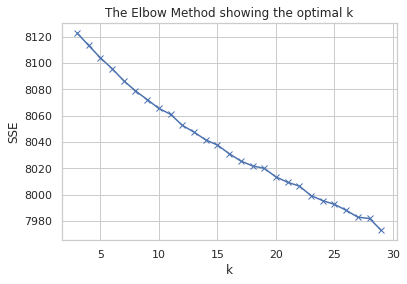

In [45]:
plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Silhouette Score

In [46]:
# nilai silhouette score antara -1 dan 1, semakin tinggil semakin bagus
print(f'Silhouette Score : {silhouette_score(features, labels = kmeans_model.labels_)}')

Silhouette Score : 0.004184973145629372


# Data Visualization

## 2 Dimensi

### PCA Dimensionality Reduction

In [17]:
pca = PCA(n_components = 2)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(synopsis_clusters.cluster_centers_)

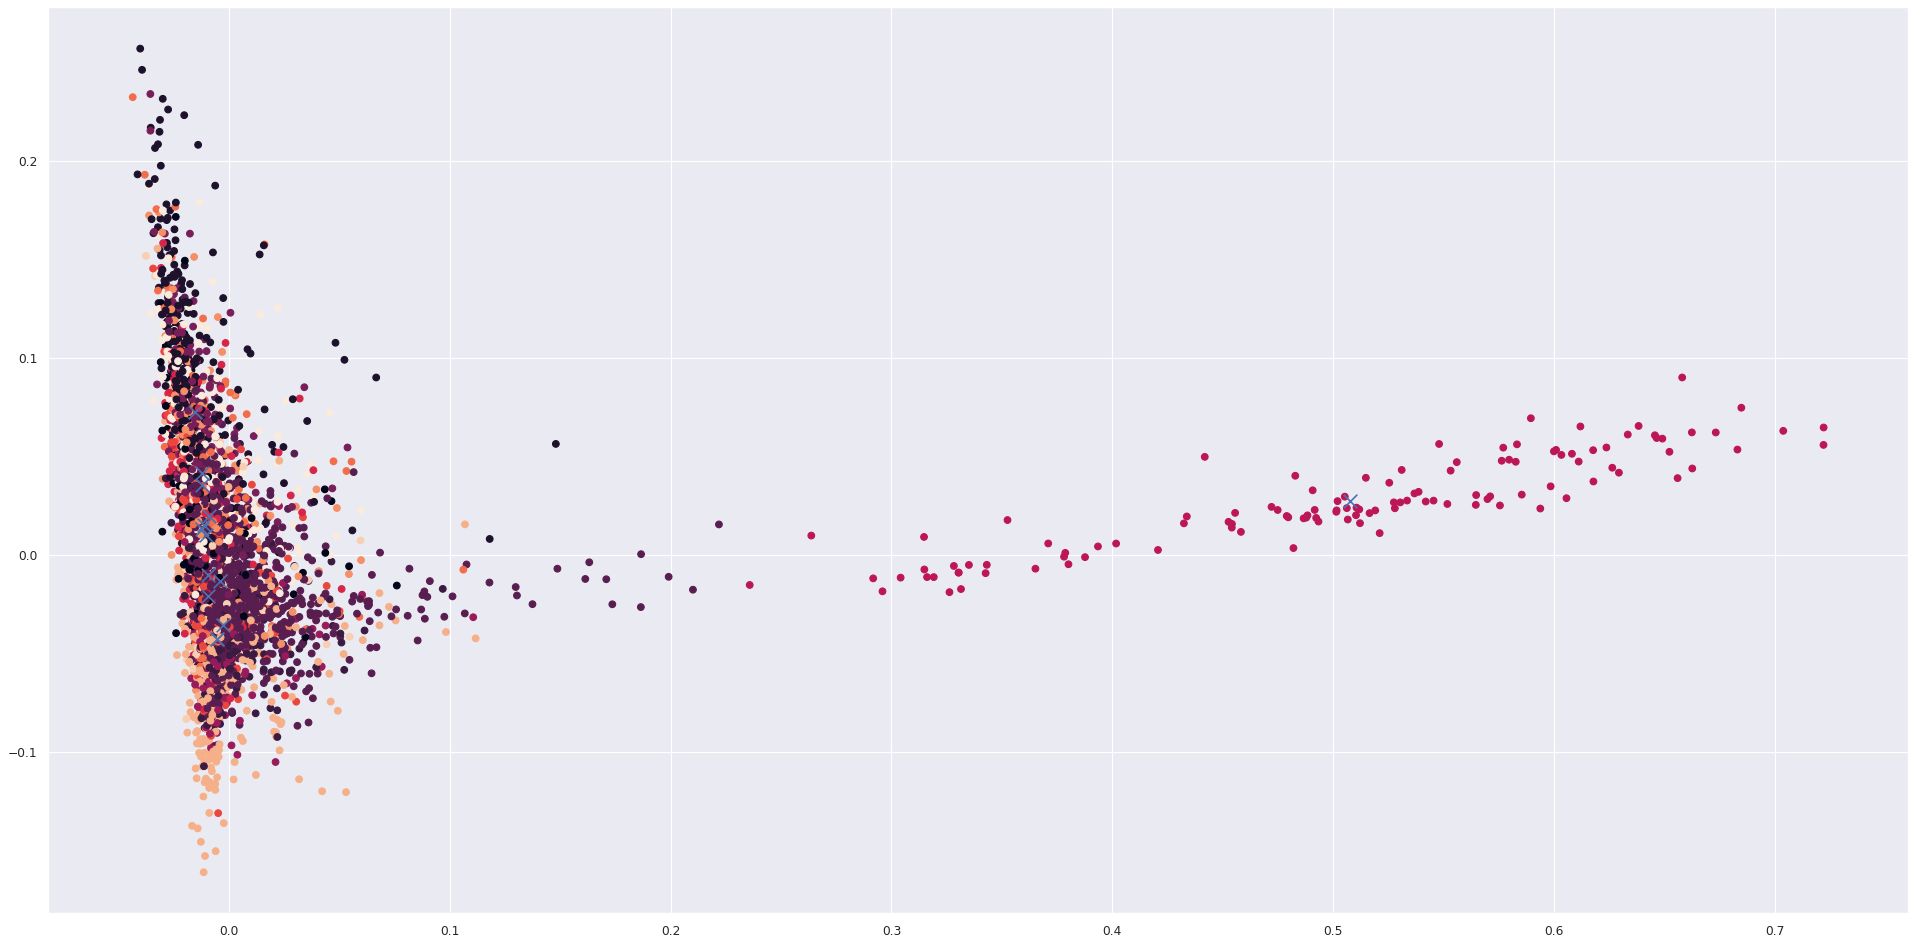

In [20]:
plt.figure(figsize=(30, 15), dpi=80)
plt.scatter(reduced_features[:, 0], reduced_features[:,1], c = kmeans_model.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

### t-SNE Dimensionality Reduction

In [ ]:
tsne = TSNE(n_components=2)
reduced_features_tsne = tsne.fit_transform(features.toarray())

In [ ]:
# Save Model
pickle.dump(tsne, open('%s/tsne.sav' % path, 'wb'))

In [ ]:
plt.figure(figsize=(30, 15), dpi=80)
plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:,1], c = kmeans_model.predict(features))

## 3 Dimensi

### PCA Dimensionality Reduction

In [18]:
pca_3d = PCA(n_components = 3)
reduced_features_3d = pca_3d.fit_transform(features.toarray())
reduced_cluster_centers_3d = pca_3d.transform(synopsis_clusters.cluster_centers_)

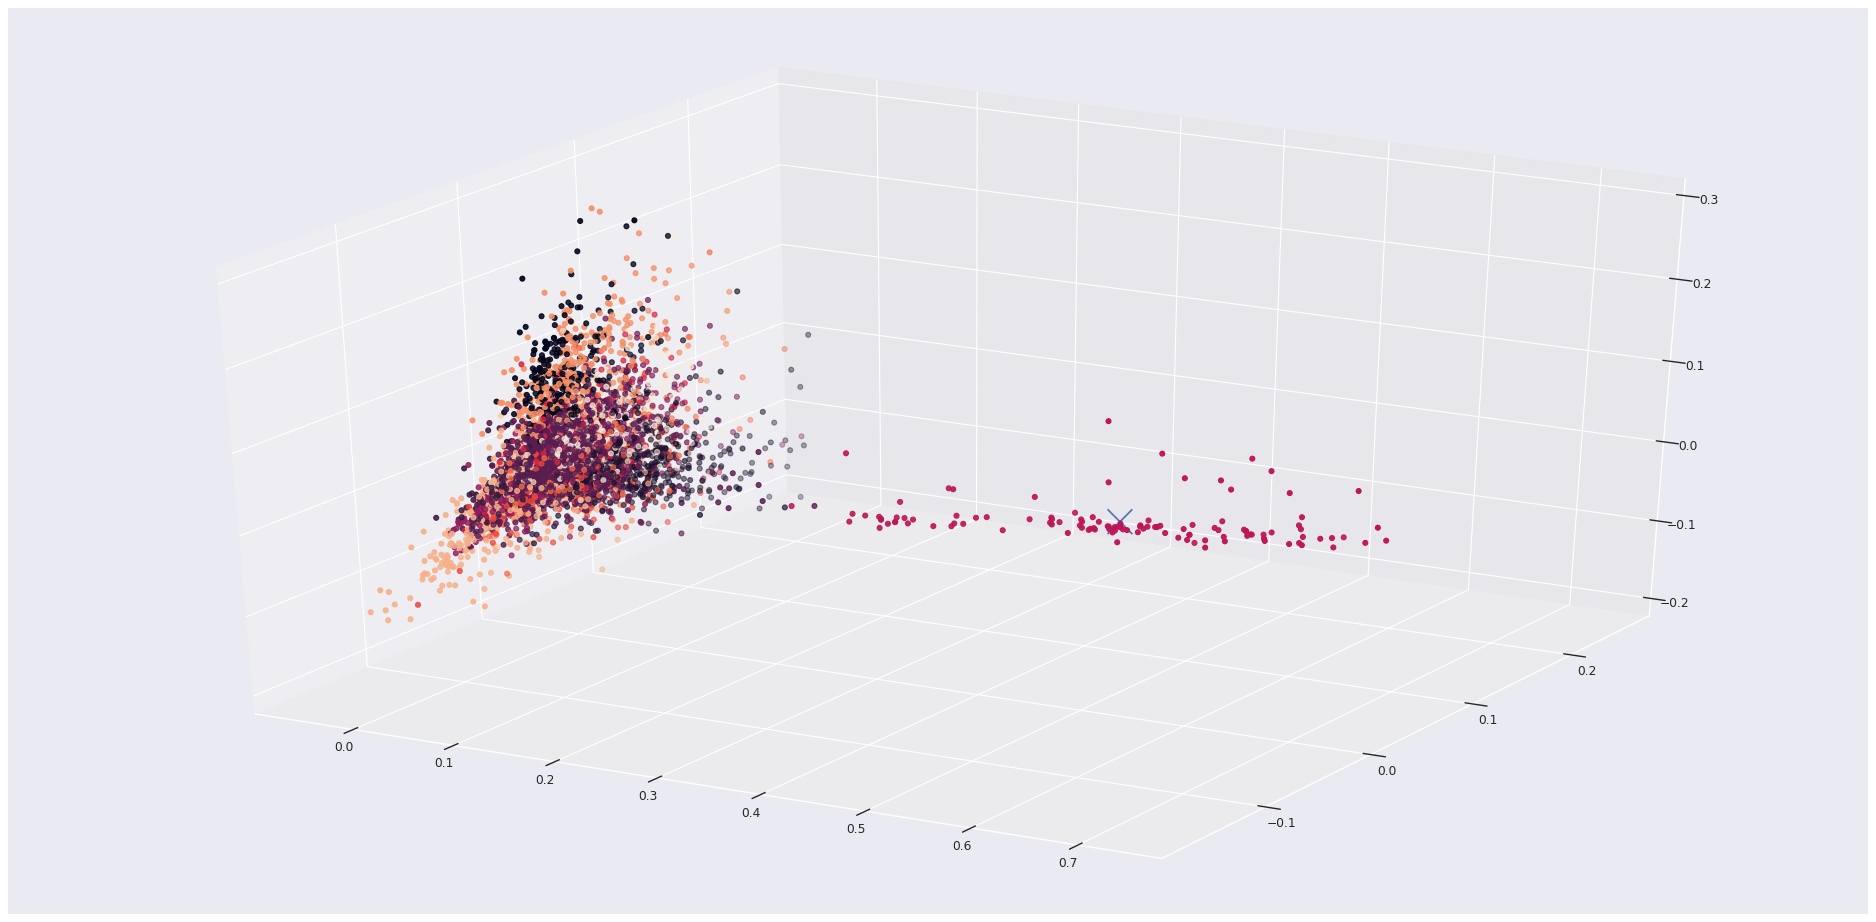

In [19]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(30, 15), dpi=80)
ax = fig.add_subplot(111, projection = '3d')

x = reduced_features_3d[:, 0]
y = reduced_features_3d[:, 1]
z = reduced_features_3d[:, 2]

ax.scatter(x, y, z, c = synopsis_clusters.labels_)
ax.scatter(reduced_cluster_centers_3d[:, 0], reduced_cluster_centers_3d[:,1], reduced_cluster_centers_3d[:,2], marker='x', s=500, c='b')

plt.show()

### t-SNE Dimensionality Reduction

In [ ]:
tsne_3d = TSNE(n_components=3)
reduced_features_3d_tsne = tsne_3d.fit_transform(features.toarray())

In [ ]:
# Save Model
pickle.dump(tsne_3d, open('%s/tsne_3d.sav' % path, 'wb'))

In [ ]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize=(30, 20), dpi=80)
ax = fig.add_subplot(111, projection = '3d')

x = reduced_features_3d_tsne[:, 0]
y = reduced_features_3d_tsne[:, 1]
z = reduced_features_3d_tsne[:, 2]

ax.scatter(x, y, z, c = synopsis_clusters.labels_)

plt.show()